In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import model_selection, metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [3]:
train_file='D:\\My Personal Documents\\Learnings\\Data Science\\Data Sets\\AmericanExpress\\train.csv'
test_file='D:\\My Personal Documents\\Learnings\\Data Science\\Data Sets\\AmericanExpress\\test.csv'
user_logs='D:\\My Personal Documents\\Learnings\\Data Science\\Data Sets\\AmericanExpress\\historical_user_logs.csv'

train=pd.read_csv(train_file)
test=pd.read_csv(test_file)
user_log=pd.read_csv(user_logs)

In [4]:
is_click_count= len(train[train.is_click==1])
non_click_indices = train[train.is_click==0].index
random_indices = np.random.choice(non_click_indices,is_click_count, replace=False)
click_indices = train[train.is_click==1].index
under_sample_indices = np.concatenate([click_indices,random_indices])
under_sample = train.loc[under_sample_indices]
train=under_sample

In [5]:
user_log_view=user_log[user_log.action=='view']
user_log_interest=user_log[user_log.action=='interest']

In [6]:
user_log_interest=user_log_interest.groupby(['user_id','product']).action.count().reset_index()

In [7]:
user_log_interest.rename(columns={'action': 'interest'}, inplace=True)
user_log_interest.head()

,user_id,product,interest
0,19,D,1
1,19,F,2
2,19,G,2
3,26,H,1
4,30,H,1


In [8]:
user_log_view=user_log_view.groupby(['user_id','product']).action.count().reset_index()

In [9]:
user_log_view.rename(columns={'action': 'view'}, inplace=True)
user_log_view.head()


,user_id,product,view
0,4,A,3
1,4,B,1
2,4,H,1
3,4,I,2
4,19,A,14


In [10]:
 user_clicked=train[train.is_click==1][['user_id','product','is_click']]

In [11]:
user_clicked.head()

,user_id,product,is_click
38,929999,H,1
54,740951,G,1
65,1005580,C,1
106,504394,C,1
107,963568,C,1


In [12]:
user_clicked.rename(columns={'is_click': 'click_score'}, inplace=True)
user_clicked.head()
#user_clicked=user_clicked.drop_duplicates

,user_id,product,click_score
38,929999,H,1
54,740951,G,1
65,1005580,C,1
106,504394,C,1
107,963568,C,1


In [13]:
user_clicked=user_clicked.drop_duplicates()

In [14]:
user_clicked.shape

(28645, 3)

In [15]:
train['source']='train'
test['source']='test'
train=train.append(test)


C:\Amrendra\Anaconda\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [16]:
user_clicked.head()

,user_id,product,click_score
38,929999,H,1
54,740951,G,1
65,1005580,C,1
106,504394,C,1
107,963568,C,1


In [17]:
train=pd.merge(train,user_log_interest,how='left', on=['user_id','product'])
train=pd.merge(train,user_log_view,how='left', on=['user_id','product'])
train=pd.merge(train,user_clicked,how='left', on=['user_id','product'])

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191520 entries, 0 to 191519
Data columns (total 19 columns):
DateTime                  191520 non-null object
age_level                 183332 non-null float64
campaign_id               191520 non-null int64
city_development_index    140003 non-null float64
gender                    183332 non-null object
is_click                  62662 non-null float64
product                   191520 non-null object
product_category_1        191520 non-null int64
product_category_2        65461 non-null float64
session_id                191520 non-null int64
source                    191520 non-null object
user_depth                183332 non-null float64
user_group_id             183332 non-null float64
user_id                   191520 non-null int64
var_1                     191520 non-null int64
webpage_id                191520 non-null int64
interest                  32742 non-null float64
view                      152569 non-null float64
click_sc

In [19]:
#t_click1=train[train.is_click==1]
#train=train.append(t_click1)
#train=train.append(t_click1)

In [20]:
train.isnull().sum()

DateTime                       0
age_level                   8188
campaign_id                    0
city_development_index     51517
gender                      8188
is_click                  128858
product                        0
product_category_1             0
product_category_2        126059
session_id                     0
source                         0
user_depth                  8188
user_group_id               8188
user_id                        0
var_1                          0
webpage_id                     0
interest                  158778
view                       38951
click_score               141842
dtype: int64

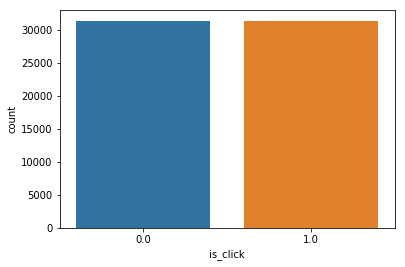

In [21]:
sb.countplot(train.is_click)

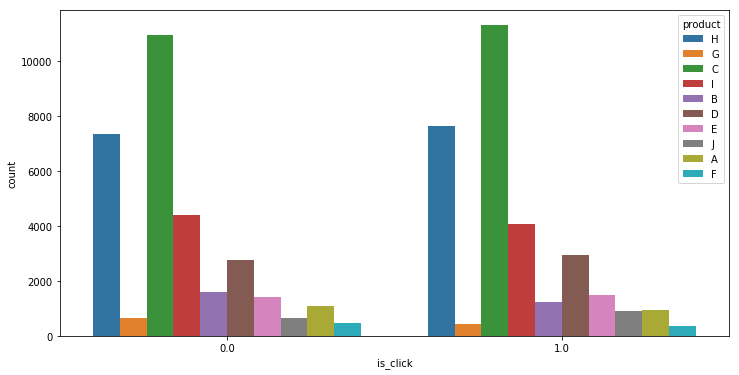

In [22]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_click', hue='product', data=train)

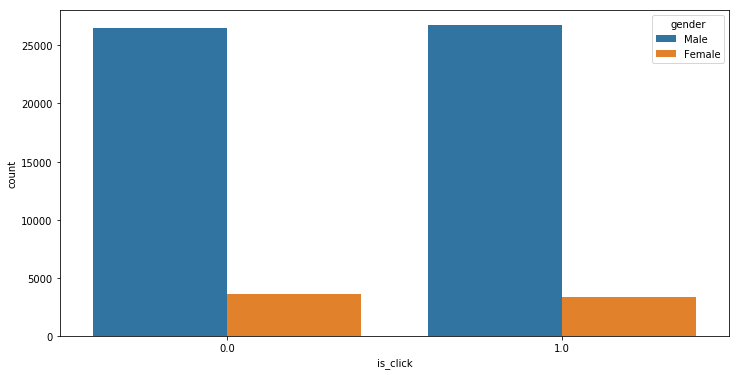

In [23]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_click', hue='gender', data=train)

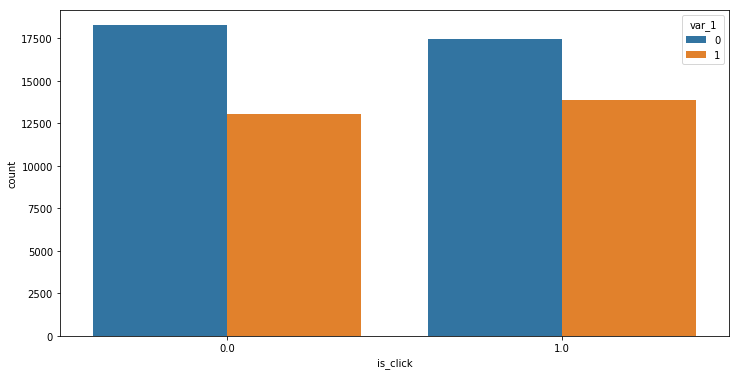

In [24]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_click', hue='var_1', data=train)

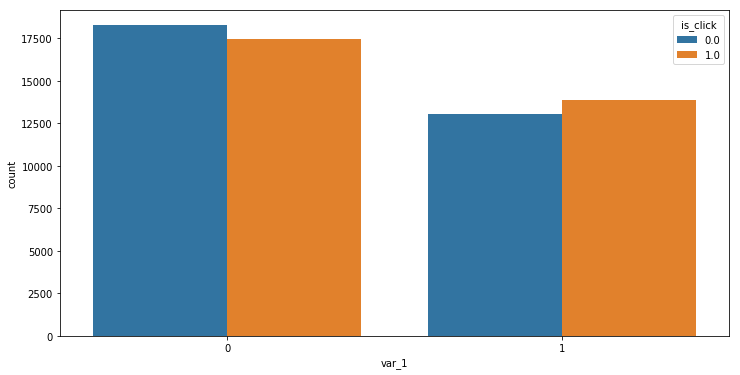

In [25]:
plt.figure(figsize=(12,6))
sb.countplot(x='var_1', hue='is_click', data=train)

In [26]:
train_label= train.is_click


In [27]:
train.gender=train.gender.fillna('Unknown')

In [28]:
train.city_development_index= train.city_development_index.fillna(method='pad')

In [29]:
train.age_level= train.age_level.fillna(method='pad')

In [30]:
train.user_depth= train.user_depth.fillna(method='pad')

In [31]:
train.user_group_id= train.user_group_id.fillna(method='pad')

In [32]:
train.view=train.view.fillna(0)
train.interest=train.interest.fillna(0)
train.click_score=train.click_score.fillna(0)

In [33]:
train=pd.get_dummies(train,columns=['gender','product'])

In [34]:
train.head()

,DateTime,age_level,campaign_id,city_development_index,is_click,product_category_1,product_category_2,session_id,source,user_depth,...,product_A,product_B,product_C,product_D,product_E,product_F,product_G,product_H,product_I,product_J
0,7/2/2017 0:05,2.0,359520,NaN,1.0,3,NaN,489923,train,2.0,...,0,0,0,0,0,0,0,1,0,0
1,7/2/2017 0:07,3.0,98970,4.0,1.0,4,NaN,419802,train,3.0,...,0,0,0,0,0,0,1,0,0,0
2,7/2/2017 0:08,3.0,359520,4.0,1.0,4,NaN,145098,train,3.0,...,0,0,1,0,0,0,0,0,0,0
3,7/2/2017 0:13,2.0,405490,4.0,1.0,3,NaN,102183,train,3.0,...,0,0,1,0,0,0,0,0,0,0
4,7/2/2017 0:13,2.0,405490,3.0,1.0,3,NaN,72843,train,3.0,...,0,0,1,0,0,0,0,0,0,0


In [35]:
train= train.drop(['DateTime','user_id','click_score','product_category_2','session_id'],axis=1)

In [36]:
train.head()

,age_level,campaign_id,city_development_index,is_click,product_category_1,source,user_depth,user_group_id,var_1,webpage_id,...,product_A,product_B,product_C,product_D,product_E,product_F,product_G,product_H,product_I,product_J
0,2.0,359520,NaN,1.0,3,train,2.0,2.0,0,13787,...,0,0,0,0,0,0,0,1,0,0
1,3.0,98970,4.0,1.0,4,train,3.0,9.0,1,6970,...,0,0,0,0,0,0,1,0,0,0
2,3.0,359520,4.0,1.0,4,train,3.0,3.0,0,13787,...,0,0,1,0,0,0,0,0,0,0
3,2.0,405490,4.0,1.0,3,train,3.0,2.0,0,60305,...,0,0,1,0,0,0,0,0,0,0
4,2.0,405490,3.0,1.0,3,train,3.0,2.0,1,60305,...,0,0,1,0,0,0,0,0,0,0


In [37]:
test=train[train.source=='test']
train=train[train.source=='train']


In [38]:
train.drop('source',axis=1,inplace=True)

In [39]:
test.drop('source',axis=1,inplace=True)

In [40]:
train_label=train.is_click

In [41]:
train=train[~(train.city_development_index.isna())]
train.isna().sum()

age_level                 0
campaign_id               0
city_development_index    0
is_click                  0
product_category_1        0
user_depth                0
user_group_id             0
var_1                     0
webpage_id                0
interest                  0
view                      0
gender_Female             0
gender_Male               0
gender_Unknown            0
product_A                 0
product_B                 0
product_C                 0
product_D                 0
product_E                 0
product_F                 0
product_G                 0
product_H                 0
product_I                 0
product_J                 0
dtype: int64

In [42]:
y_train=train['is_click']
x_train=train.drop(['is_click'],axis=1).values
x_test=test.drop(['is_click'],axis=1).values
#y_test=titanic_result.Survived

In [43]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

param_grid = {
    'bootstrap': [True],
    'max_depth': [3,5,8],
    'max_features':[3,4,5,6],
    'n_estimators': [150,300,500] 
}

rf=RandomForestClassifier()
grid_search=GridSearchCV(estimator=rf,param_grid=param_grid,cv=3,n_jobs=-1,verbose=2)

In [44]:
grid_search.fit(x_train,y_train)
print(grid_search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 10.6min finished


{'bootstrap': True, 'max_depth': 3, 'max_features': 3, 'n_estimators': 150}


In [45]:
best_grid=grid_search.best_estimator_
best_grid.fit(x_train,y_train)
y_pred=best_grid.predict(x_test)
#print(confusion_matrix(y_test,y_pred))

In [46]:
prediction=pd.Series(y_pred.tolist()).astype(int)
prediction.to_csv('D:/My Personal Documents/Learnings/Data Science/Data Sets/AmericanExpress/prediction.csv')